In [2]:
import matplotlib.pyplot as plt
import pandas as pd

Text(0.5, 0, 'Time (s)')

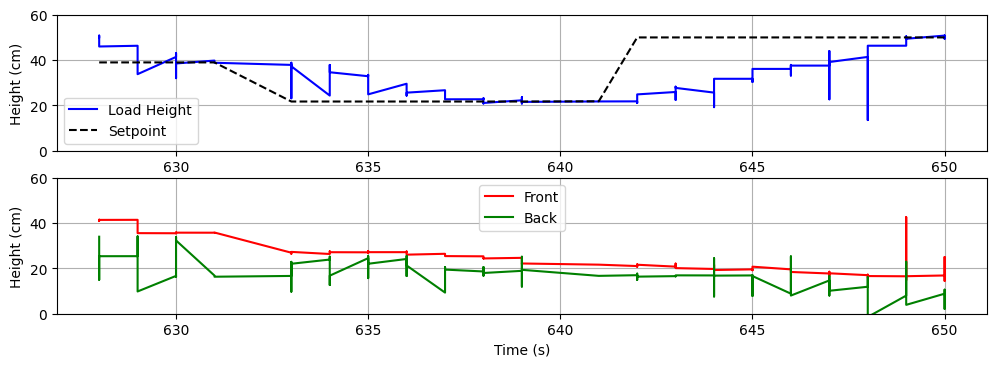

In [31]:
df = pd.read_csv("data.csv").set_index("Time")
height = 60
if height > 0:
    df["Winch Distance"] = height - df["Winch Distance"]
    df["North Distance"] = height - df["North Distance"]
    df["South Distance"] = height - df["South Distance"]
    df["Setpoint"] = height - df["Setpoint"]

plt.figure(figsize = (12, 6))

# the load plot
plt.subplot(3, 1, 1)
plt.plot(df["Winch Distance"], "b", label = "Load Height")
plt.plot(df["Setpoint"], "k--", label = "Setpoint")
plt.ylabel("Height (cm)")
plt.ylim(0, 60)
plt.grid()
plt.legend()

# the obstacle plot
plt.subplot(3, 1, 2)
plt.plot(df["North Distance"], "r", label = "Front")
plt.plot(df["South Distance"], "g", label = "Back")
plt.ylabel("Height (cm)")
plt.ylim(0, 60)
plt.grid()
plt.legend()

# the actuator response plot
# plt.subplot(3, 1, 3)
# plt.plot(df["Winch Action"], "b--", label = "Winch Motor")
# plt.plot(df["Side ACtion"], "r--", label = "Side Action")
# plt.ylabel("Actuator Response")
# plt.grid()
# plt.legend()
plt.xlabel("Time (s)")